#### Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
df = pd.read_csv('store.csv')

#### Exploring Data

In [5]:
df.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [8]:
df.sort_values(by=['date','store'], inplace=True)

In [9]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [10]:
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d")
df.set_index('date', inplace=True)

#### Exploratory Data Analysis

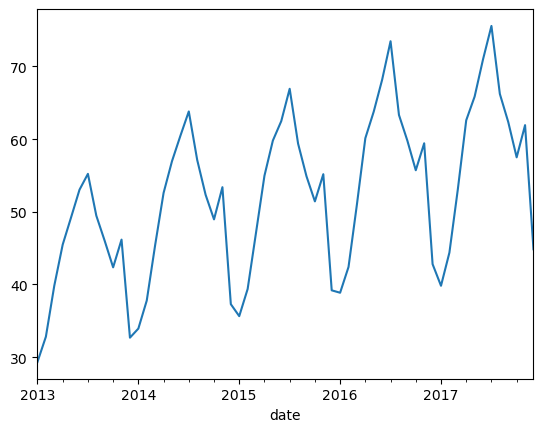

In [12]:
df['sales'].resample('ME').mean().plot()    #'ME' means monthly
plt.show()

This shows the clear cyclical peaks and troughs in the sales, showing seasonal patterns.

Sales tend to fall early start of the year and rise at middle of the year.

From 2013 to 2017, the general trend seems slightly increasing, which indicates gradual growth in sales over time.

The plot shows both trend and seasonality making it well-suited for models like SARIMA or SARIMAX.

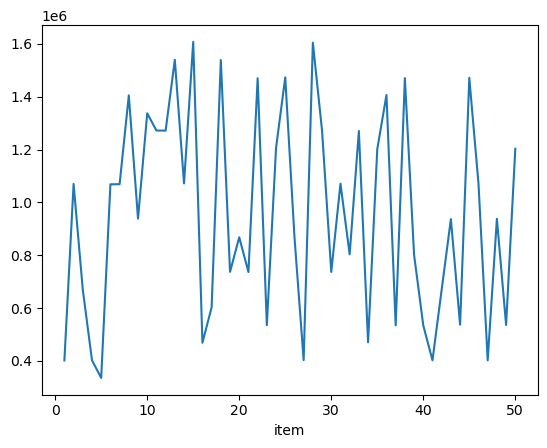

In [14]:
item_sales = df.groupby('item')['sales'].sum()
item_sales.plot()
plt.show()

The sales for the 50 items show significant fluctuations. There are both high and low sales points.

There is no apparent trend in the data. Sales do not follow a pattern.

In [16]:
store = df['store'].unique().max()
item = df['item'].unique().max()

for i in range(1, store + 1):  
    for j in range(1, item + 1):  
        filtered_data = (df[(df['store'] == i) & (df['item'] == j)])
        count = filtered_data.shape[0]
        total_sales = filtered_data['sales'].sum()
        print(f"Store {i}, Item {j}: Count = {count}, Total sales = {total_sales}")

Store 1, Item 1: Count = 1826, Total sales = 36468
Store 1, Item 2: Count = 1826, Total sales = 97050
Store 1, Item 3: Count = 1826, Total sales = 60638
Store 1, Item 4: Count = 1826, Total sales = 36440
Store 1, Item 5: Count = 1826, Total sales = 30335
Store 1, Item 6: Count = 1826, Total sales = 96889
Store 1, Item 7: Count = 1826, Total sales = 96383
Store 1, Item 8: Count = 1826, Total sales = 126856
Store 1, Item 9: Count = 1826, Total sales = 84918
Store 1, Item 10: Count = 1826, Total sales = 121163
Store 1, Item 11: Count = 1826, Total sales = 115436
Store 1, Item 12: Count = 1826, Total sales = 115465
Store 1, Item 13: Count = 1826, Total sales = 139067
Store 1, Item 14: Count = 1826, Total sales = 97050
Store 1, Item 15: Count = 1826, Total sales = 145497
Store 1, Item 16: Count = 1826, Total sales = 42605
Store 1, Item 17: Count = 1826, Total sales = 54729
Store 1, Item 18: Count = 1826, Total sales = 139407
Store 1, Item 19: Count = 1826, Total sales = 66972
Store 1, Item 

The above data tells us the item sales in each store.

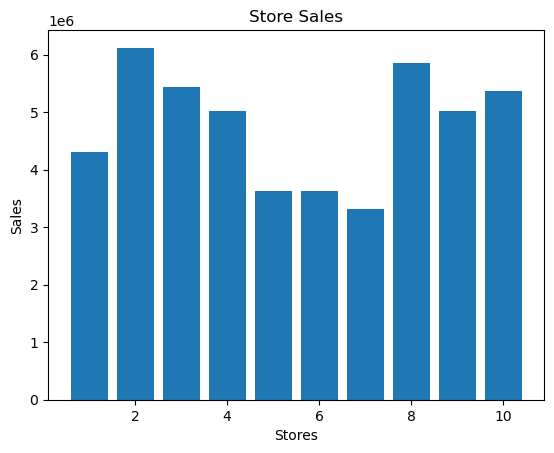

In [18]:
store_sales = df.groupby('store')['sales'].sum()

plt.bar(store_sales.index, store_sales.values)
plt.title('Store Sales')
plt.xlabel('Stores')
plt.ylabel('Sales')
plt.show()

Stores 2 and 8 are performing significantly better than the other stores.

There is a wide variation in sales performance between stores.

In [20]:
df['store'] = df['store'].astype('str')

In [21]:
monthly_data = df.groupby(['store', 'item', 'month', 'year'])['sales'].sum().reset_index()

monthly_data = monthly_data.set_index('month')

In [22]:
store_item_monthly = monthly_data[(monthly_data['store'] == '1') & (monthly_data['item'] == 1)]

store_item_monthly.groupby(['store', 'item'])

In [23]:
store_item_monthly

,store,item,year,sales
month,,,,
1,1,1,2013,328
1,1,1,2014,435
1,1,1,2015,428
1,1,1,2016,449
1,1,1,2017,485
2,1,1,2013,322
2,1,1,2014,405
2,1,1,2015,399
2,1,1,2016,450


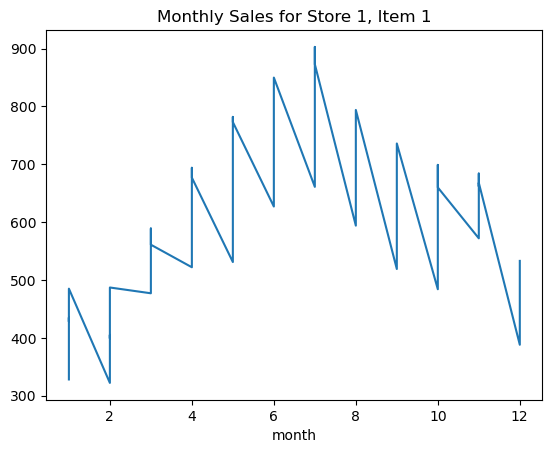

In [24]:
store_item_monthly['sales'].plot(title="Monthly Sales for Store 1, Item 1")
plt.show()

We can take a look at each items monthly sales in the specific store.

The above visual is an example for monthly sales for item 1 in store 1. We can see that the sales are more in the middle of the year and low on the start and end of the year.

In [26]:
result = adfuller(monthly_data['sales'])
p_value = result[1]
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Stationary' if p_value < 0.05 else 'Non-Stationary')

ADF Statistic: -14.811105129259577
p-value: 2.0297730762514087e-27
Stationary


This above result tells us whether the data is stationary or not.
Stationary refers to statistical properties of a time series remaining constant over time.

In [28]:
month_sales = df['sales'].resample('ME').mean()

In [29]:
month_sales.head()

date
2013-01-31    29.348645
2013-02-28    32.815500
2013-03-31    39.831097
2013-04-30    45.484933
2013-05-31    49.241419
Freq: ME, Name: sales, dtype: float64

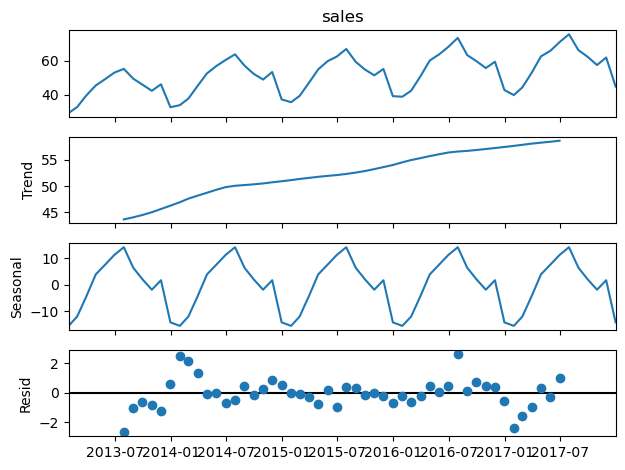

In [30]:
decomposition = seasonal_decompose(month_sales, model='additive', period=12)
decomposition.plot()
plt.show()

The seasonal decomposition is splot into trend, seasonality, and residual components.
- The trend shows a long-term growth
- The seasonal component shows repeating patterns across months, indicating seasonality
- The residuals appeared random, indicating that most of the structure in the data had been captured.

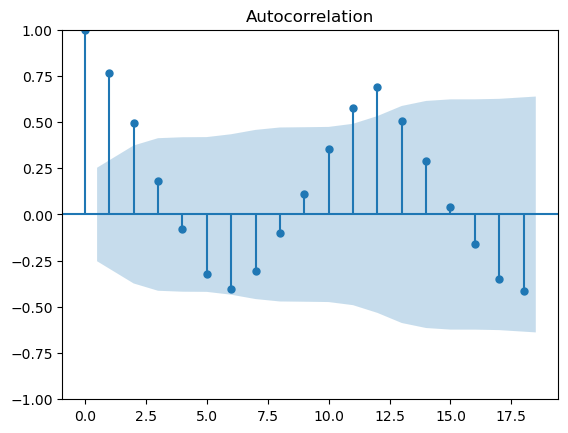

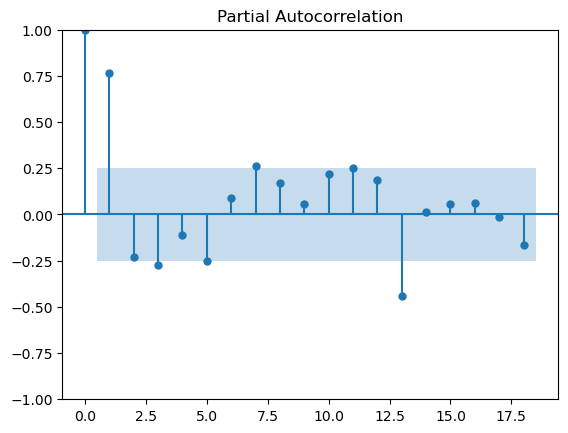

In [32]:
plot_acf(month_sales)
plot_pacf(month_sales)
plt.show()

Autocorrelation
- This plot exhibits a storng correlation with its previous value.
- The autocorrelation for lags beyond 1 are within the confidence bounds, indicating a stationary process. 
- It suggest a potential use of AR(1) model (Autoregressive model with order 1) for forecasting or modeling the time series.

Partial Autocorrelation 
- This plot indicates the current value of the time series is influenced by its immediate past value, with minimal influence from values further back.
- This suggets the idea of a potentially simple autoregressive model, such as AR(1), being suitable for modeling the time series.

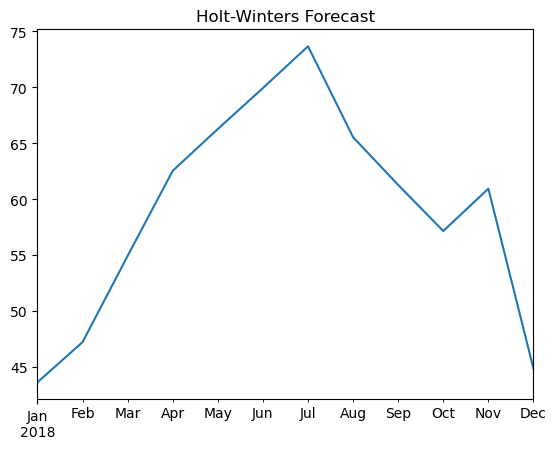

In [35]:
hw_model = ExponentialSmoothing(month_sales,seasonal='add',seasonal_periods=12).fit()

hw_forecast = hw_model.forecast(steps=12)
hw_forecast.plot(title='Holt-Winters Forecast')
plt.show()

This forecast indicates an expected increase in sales over the upcoming period which is the year 2018.

The trend line shows suggets a consistent moving upward indicating that sales are likely to rise when it is at the peak showing seasonality. 

#### Demand Forecast Using SARIMAX

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [39]:
model = SARIMAX(month_sales, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

C:\Users\chara\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


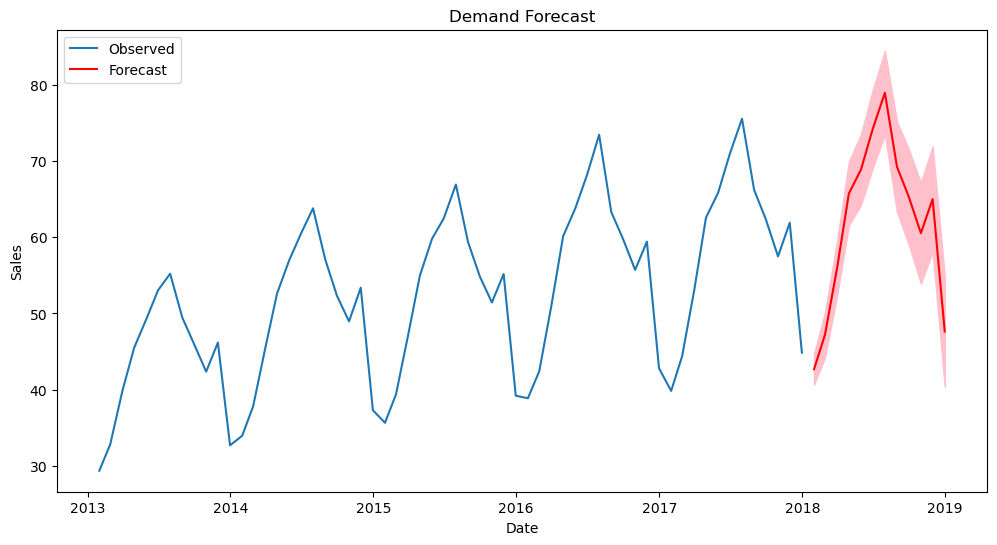

In [40]:
# Forecast future values
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(month_sales, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Demand Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

Findings:
- The forecast shows that the demand is expected to increase over time.
- The forecast suggests that the demand will be higher in 2019 as compared to the past years.
- The confidence interval shows that the forecast is uncertain. The actual demand could be higher or lower than the predicted demand.

In [42]:
observed = month_sales[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 3.0310714963002336
MSE: 9.21773510533628


MAE of 3.03 indicates that on average, the forecast is off by about 3.03 units of sales.

MSE of 9.22 suggests that the squared difference between the actual and predicted values is 9.22.

Overall, the model seems to perform fairly well, with relatively low MAE and MSE values.